In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("tree_term_climb.R"))
suppressPackageStartupMessages(library(beaveR))
suppressPackageStartupMessages(library(TreeSummarizedExperiment))

saveDir <- "environment/Chimp/DE"
load(file.path(saveDir, "tseChimp.RData"))
load(file.path(saveDir, "y.RData"))
load(file.path(saveDir, "gy.RData"))

treeCons <- rowTree(tseChimp)
l <- length(treeCons$tip)
termFile <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old/PTB162LA1C/clusters.txt"

In [2]:
load(file.path(saveDir, "treeDEFDR_OL.RData"))
load(file.path(saveDir, "bSwishConsFDR_OL.RData"))

In [3]:
suppressPackageStartupMessages(source("old_terminus_helper.R"))
yTermThrNS <- tseChimp[1:l,]
groupsClust <- parseClustFile(termFile, yTermThrNS)
mInds <- seq(nrow(yTermThrNS) + length(groupsClust))
yAggTermThrNS <- prepOSwish(yTermThrNS, mInds, groupsClust)
yTerm <- yAggTermThrNS[-unlist(groupsClust),]
yTerm <- fishpond::scaleInfReps(yTerm)
yTerm <- labelKeep(yTerm)
set.seed(10)
yTerm <- swish(yTerm, x="tissue")

In [6]:
detNodes <- list()
detNodes[["Txps"]] <- lapply(c(0.01, 0.05, 0.1), function(x) which(mcols(y)[,"qvalue"] <= x ))
detNodes[["treeDEFDR_OL"]] <- lapply(treeDEFDR_OL[["mIRV=0.4"]], function(ta) ta)
detNodes[["treeClimbR"]] <- lapply(bSwish, function(sw) sw$output[sw$output$signal.node,][["node"]])
detNodes[["treeClimbRO"]] <- lapply(bSwish, function(sw) unlist(Descendants(treeCons,sw$output[sw$output$signal.node,][["node"]])))
detNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[which(mcols(yTerm)[,"qvalue"] <= x)]
        match(nodes, names(yAggTermThrNS))
    })
detNodes[["gene"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        which(mcols(gy)[["qvalue"]] <= x)
    })

                                    
negNodes <- list()
negNodes[["Txps"]] <- lapply(detNodes[["Txps"]], function(nodes) setdiff(seq(l), nodes))
negNodes[["treeDEFDR_OL"]] <- lapply(detNodes[["treeDEFDR_OL"]], function(nodes) setdiff(seq(nrow(y)), unlist(Descendants(treeCons, nodes))))
negNodes[["treeClimbR"]] <- lapply(detNodes[["treeClimbR"]], function(det) setdiff(seq(nrow(y)), unlist(Descendants(treeCons, det))))
negNodes[["treeClimbRO"]] <- lapply(detNodes[["treeClimbRO"]], function(det) setdiff(seq(nrow(y)), det))
negNodes[["term"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        nodes <- rownames(yTerm)[setdiff(seq(nrow(yTerm)),
                                                 which(mcols(yTerm)[,"qvalue"] <= x))]
        match(nodes, names(yAggTermThrNS))
    })
negNodes[["gene"]] <- lapply(c(0.01, 0.05, 0.1), function(x) {
        which(mcols(gy)[["qvalue"]] > x)
    })

In [18]:
treeDETxps <- rownames(tseChimp)[unlist(Descendants(treeCons, detNodes[["treeDEFDR_OL"]][[3]]))]
treeClimbTxps <- rownames(tseChimp)[unlist(Descendants(treeCons, detNodes[["treeClimbR"]][[3]]))]
dGETxps <- unlist(rowData(gy)[detNodes[["gene"]][[3]], "tx_ids"])

In [24]:
head(treeDETxps)
head(dGETxps)

[1] "ENSPTRT00000097029.1" "ENSPTRT00000107769.1" "ENSPTRT00000076390.1"
[4] "ENSPTRT00000076387.1" "ENSPTRT00000076402.1" "ENSPTRT00000076397.1"

ENSPTRG00000000008   ENSPTRG00000000017   ENSPTRG00000000017 
"ENSPTRT00000000015" "ENSPTRT00000061948" "ENSPTRT00000061949" 
  ENSPTRG00000000021   ENSPTRG00000000024   ENSPTRG00000000025 
"ENSPTRT00000000044" "ENSPTRT00000000050" "ENSPTRT00000064008"

In [19]:
dN <- detNodes[["term"]][[3]]

termTxps <- c(rownames(yAggTermThrNS)[dN][startsWith(rownames(yAggTermThrNS)[dN], "ENS")],
  rownames(yAggTermThrNS)[as.numeric(unlist(groupsClust[rownames(yAggTermThrNS)[dN][!startsWith(rownames(yAggTermThrNS)[dN], "ENS")]]))])

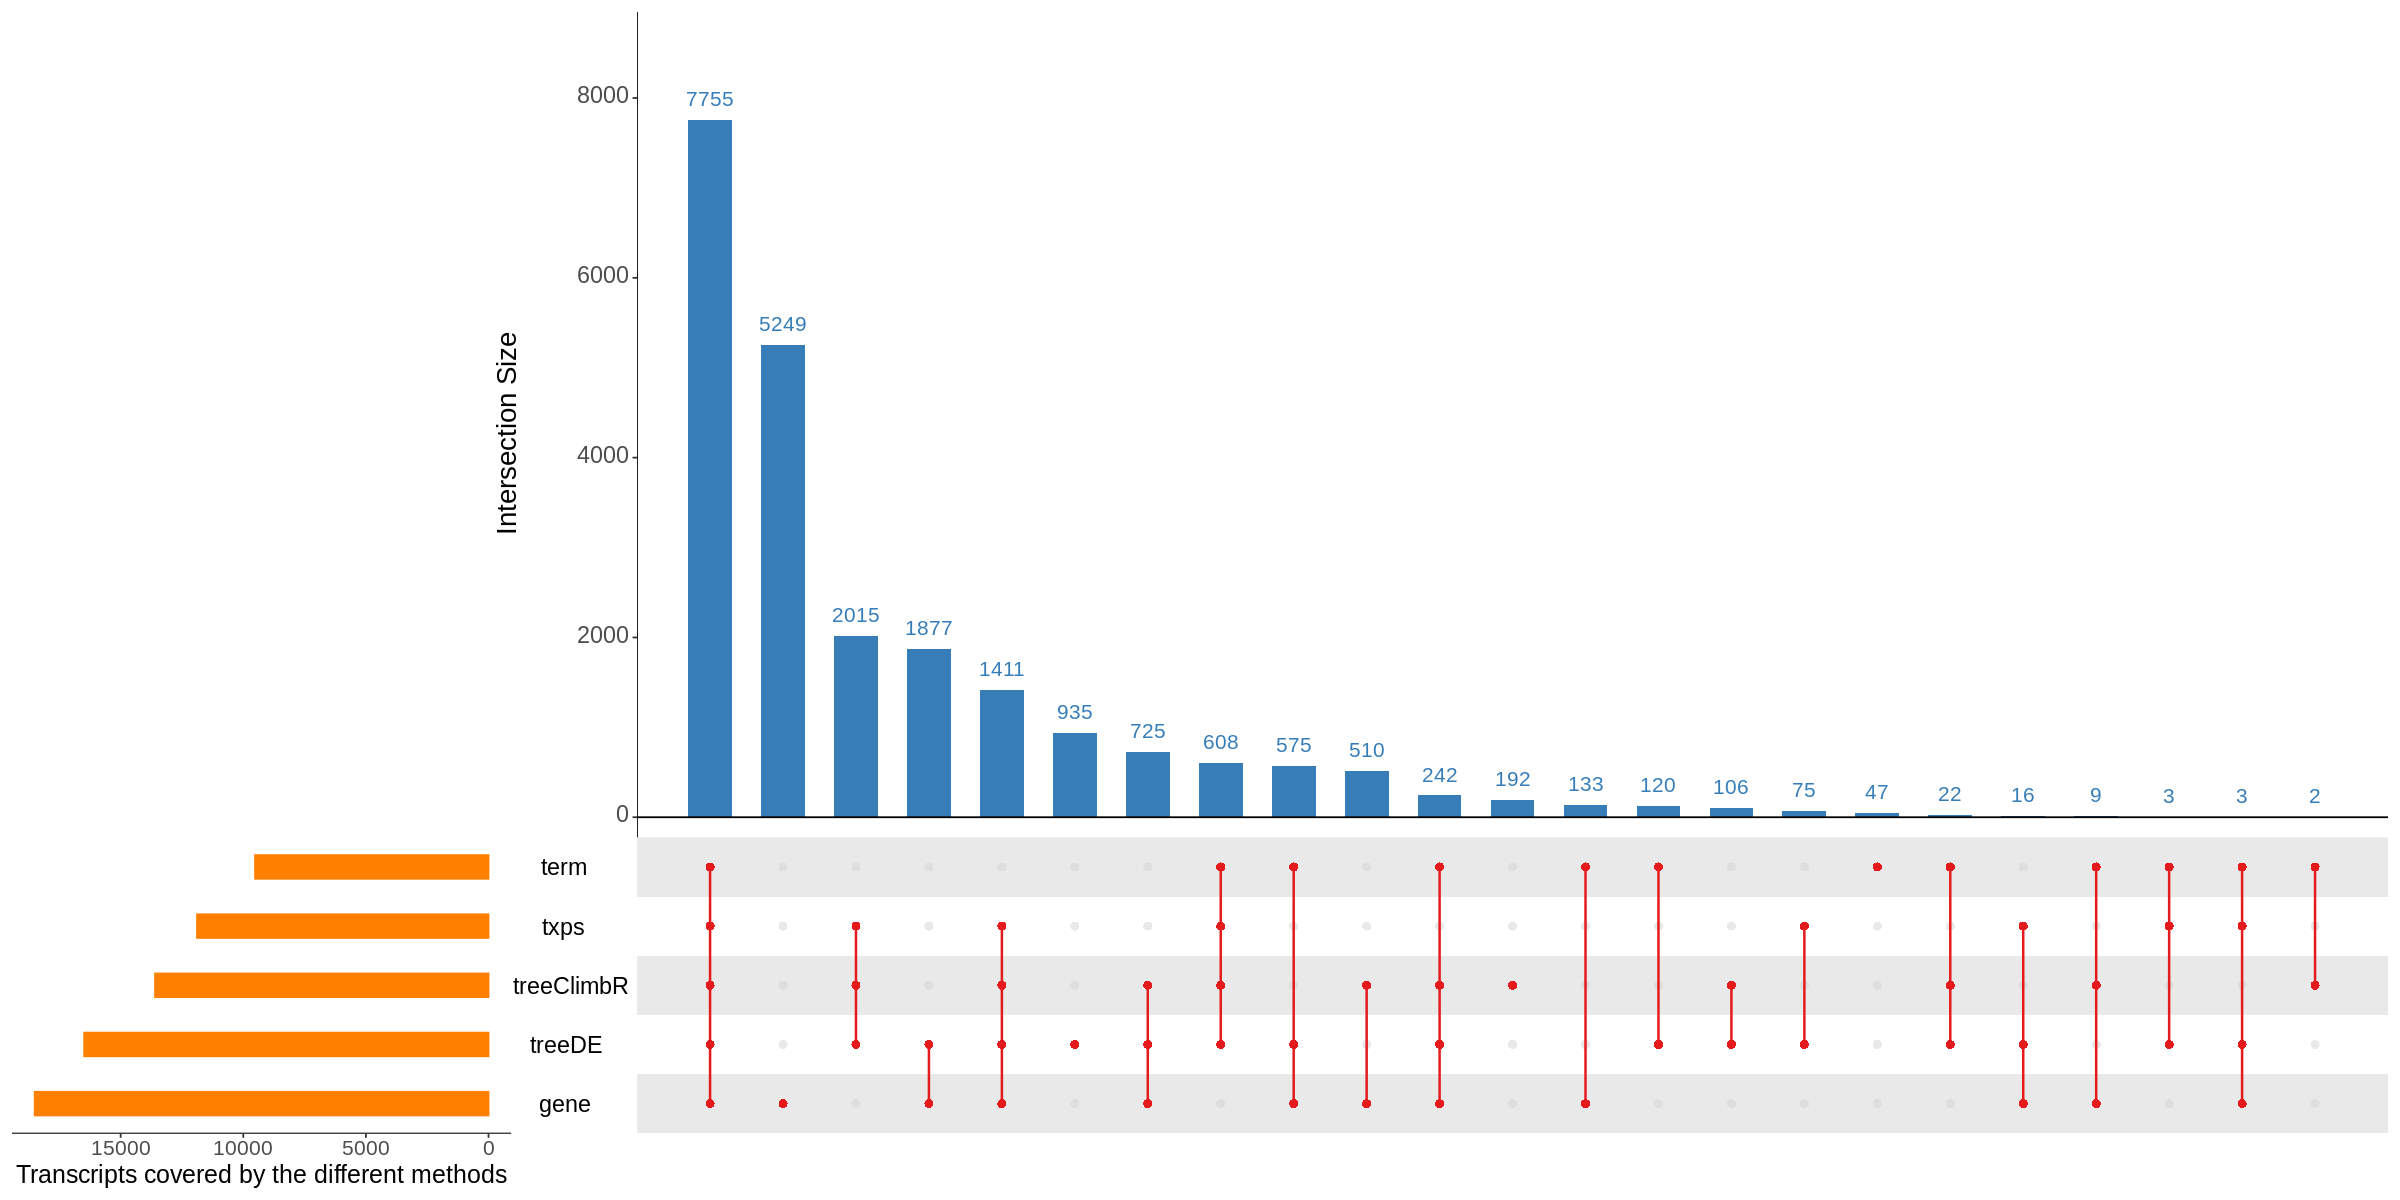

In [27]:
options(repr.plot.width=20, repr.plot.height=10)
suppressPackageStartupMessages(library(UpSetR))
txpMethods = list(txps = rowData(tseChimp)[rownames(y)[detNodes[[1]][[3]]],"TXNAME"], 
                 treeDE = rowData(tseChimp)[treeDETxps,"TXNAME"], 
                 treeClimbR = rowData(tseChimp)[treeClimbTxps,"TXNAME"], 
                 term = rowData(tseChimp)[termTxps,"TXNAME"],
                 gene = dGETxps)
upsetData <- fromList(txpMethods)
size <- 2
upset(upsetData, order.by = "freq",
     main.bar.color = "#377eb8", 
     matrix.color = "#e41a1c",
     sets.bar.color = c("#ff7f00"),
     sets.x.label = "Transcripts covered by the different methods",
     shade.alpha = 0.7, 
     text.scale = c(size, size, 1.8, 1.8, size, size)
)



In [26]:
rowData(tseChimp)

DataFrame with 72118 rows and 2 columns
                                 TXNAME             GENEID
                            <character>        <character>
ENSPTRT00000056608.3 ENSPTRT00000056608 ENSPTRG00000029293
ENSPTRT00000097029.1 ENSPTRT00000097029 ENSPTRG00000045967
ENSPTRT00000078887.1 ENSPTRT00000078887 ENSPTRG00000045563
ENSPTRT00000107769.1 ENSPTRT00000107769 ENSPTRG00000047067
ENSPTRT00000110338.1 ENSPTRT00000110338 ENSPTRG00000048116
...                                 ...                ...
Node72114                     Node72114                  2
Node72115                     Node72115                  2
Node72116                     Node72116                  2
Node72117                     Node72117                  2
Node72118                     Node72118                  2